# Homework

## 3. Implementation

### 3.1. Data Processing

1. The first cells of the notebook are the same as in the TP on text convolution. Apply the same preprocessing to get a dataset (with the same tokenizer) with a train and a validation split, with two columns review_ids (list of int) and label (int).

**ANSWER** : Copying what we did in the TP on text convolution.

In [120]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from tabulate import tabulate
from datasets import load_dataset

from tqdm import tqdm
from transformers import BertTokenizer

import functools
from typing import Any
import gc

print("Version de pytorch : ", torch.__version__)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

Version de pytorch :  2.3.0+cu121


device(type='cuda')

In [121]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


In [122]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [123]:
print("Type of the tokenizer:", type(tokenizer.vocab))
VOCSIZE = len(tokenizer.vocab)
print("Length of the vocabulary:", VOCSIZE)
print(str(tokenizer.vocab)[:50])

Type of the tokenizer: <class 'collections.OrderedDict'>
Length of the vocabulary: 30522
OrderedDict({'[PAD]': 0, '[unused0]': 1, '[unused1


In [124]:
def preprocessing_fn(x, tokenizer):
    x["review_ids"] = tokenizer(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding='max_length',
        return_attention_mask=False,
    )["input_ids"]
    x["label"] = 0 if x["sentiment"] == "negative" else 1
    return x

In [9]:
n_samples = 5000  # the number of training example

# We first shuffle the data !
dataset = dataset.shuffle(seed=0)

# Select 5000 samples
sampled_dataset = dataset.select(range(n_samples))

# Tokenize the dataset
sampled_dataset = sampled_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer" : tokenizer}
)

In [10]:
# Remove useless columns
sampled_dataset = sampled_dataset.select_columns(['review_ids','label'])

# Split the train and validation
splitted_dataset = sampled_dataset.train_test_split(test_size=0.2)

document_train_set = splitted_dataset['train']
document_valid_set = splitted_dataset['test']

2. Write a function extract_words_contexts. It should retrieve all pairs of valid $(w, C^+)$ from a list of ids representing a text document. It takes the radius $R$ as an argument. Its output is therefore two lists :

to make sure that every C has the same size, we add paddings at the beginning and the end of the sentence. For example the first word of the sentence, will have R paddings corresponding to the R tokens that should be before. We can also use the token itself, so that it has a high dot product with itself.

In [11]:
tokenizer.pad_token_id

0

In [12]:
def extract_words_contexts(sample, R):
    token_ids = sample["review_ids"]
    n_tokens = len(token_ids)
    positive_context = []
    token_ids_with_padding = [0]*R + token_ids + [0]*R
    for i in range(n_tokens) :
        # if out of bounds
        if i<R or i>=n_tokens-R :
            positive_context.append([token_ids_with_padding[i+r] for r in range(R)] + [token_ids_with_padding[i+R+r] for r in range(1,R+1, 1)])
        else :
            positive_context.append([token_ids[i+r] for r in range(-R, 0, 1)] + [token_ids[i+r] for r in range(1, R+1, 1)])
            # positive_context.append([token_ids[i-R:i]] + [tokens_ids[i+1:i+R+1]])
    return token_ids, positive_context

In [13]:
toto, test = extract_words_contexts(document_train_set[2], 3)

In [14]:
print("First 5 tokens :", toto[:5])
print("C+ of the first 5 tokens :")
test[:5]

First 5 tokens : [2023, 2003, 4089, 2026, 8837]
C+ of the first 5 tokens :


[[0, 0, 0, 2003, 4089, 2026],
 [0, 0, 2023, 4089, 2026, 8837],
 [0, 2023, 2003, 2026, 8837, 2143],
 [2023, 2003, 4089, 8837, 2143, 1012],
 [2003, 4089, 2026, 2143, 1012, 1037]]

3. Write a function flatten_dataset_to_list that applies the function extract_words_contexts on a whole dataset.

In [15]:
def flatten_dataset_to_list(dataset, R):
    '''takes a dataset and returns the token_ids and positive context'''
    token_ids = []
    positive_contexts = []
    for sample in dataset:
        sample_token_ids, positive_context = extract_words_contexts(sample, R)
        token_ids.append(sample_token_ids)
        positive_contexts.append(positive_context)
    return token_ids, positive_contexts

4. Apply the function to your initial document_train_set and document_valid_set, and get the corresponding flattened lists.

In [16]:
R = 2
token_ids, positive_contexts = flatten_dataset_to_list(document_train_set, R)

5. Embed these lists in two valid PyTorch Dataset, like in HW 1, call them train_set and valid_set.

In [17]:
class CustomDataset(Dataset):

    def __init__(self, document_set, R):
        self.document_set = document_set
        token_ids, positive_contexts = flatten_dataset_to_list(document_set, R)
        self.token_ids = torch.tensor(token_ids)
        self.positive_contexts = torch.tensor(positive_contexts)

    def __len__(self):
        return len(self.token_ids)

    def __getitem__(self, idx):
        return {
            "word_id" : self.token_ids[idx], 
            "positive_context_ids" : self.positive_contexts[idx],
            # "label" : torch.tensor(self.document_set[idx]["label"])
        }

In [18]:
train_set = CustomDataset(document_train_set, R)
valid_set = CustomDataset(document_valid_set, R)

In [19]:
len(valid_set), len(train_set)

(1000, 4000)

In [20]:
try :
    valid_set[951], train_set[1347:-2000]
except :
    print("error")

6. Write a collate_fn function that adds the negative context to the batch. It should be parametrized by the scaling factor K.

In [137]:
def collate_fn(batch, R, K, VOCSIZE):
    ''' batch is a slice of the Dataset instance created above, of dictionaries with keys "word_id", "positive_context_ids" and "label" which contain tensors
    What we want is that the output becomes a dictionary with keys :
    - "word_id", which contains the all the token_ids for every review in the batch. It should be a tensor of shape (batch_size, n_tokens=256)
    - "positive_context_ids", which contains the positive context of all tokens for every review in the batch. 
      It should be a tensor of shape (batch_size, n_tokens, 2R)
    - "negative_context_ids", same thing for negative context. It should be a tensor of shape (batch_size, n_tokens, 2RK)
    '''
    batch_size = len(batch)
    n_tokens = len(batch[0]["word_id"])
    result = dict()
    
    result["word_id"] = torch.stack([review["word_id"] for review in batch])
    result["positive_context_ids"] = torch.stack([review["positive_context_ids"] for review in batch])
    # sample 2RK tokens from the vocabulary for each token in each review in the batch -> reshape it -> convert to a tensor
    result["negative_context_ids"] = torch.tensor(
        np.random.choice(np.arange(VOCSIZE), 2*R*K*n_tokens*batch_size, replace=True)\
            .reshape(batch_size, n_tokens, 2*R*K)
    )
    return result

7. Wraps everything in a DataLoader, like in HW 1.

In [24]:
batch_size = 32
R = 2
K = 2
collate_fn_with_params = functools.partial(collate_fn, R=R, K=K, VOCSIZE=VOCSIZE)

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=collate_fn_with_params
)   
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=collate_fn_with_params
)
n_valid = len(valid_set)
n_train = len(train_set)

8. Make 2 or 3 three iterations in the DataLoader and print R, K and the shapes of all the tensors in the batches (let the output be visible).

In [25]:
print("R =", R)
print("K =", K)

for i, batch in enumerate(train_dataloader):
    print(f"batch {i} :")
    print(batch.keys())
    for key, value in batch.items():
        print(f"'{key}' shape :", value.shape)
    print("-"*50)
    
    if i > 2:
        break

R = 2
K = 2
batch 0 :
dict_keys(['word_id', 'positive_context_ids', 'negative_context_ids'])
'word_id' shape : torch.Size([32, 256])
'positive_context_ids' shape : torch.Size([32, 256, 4])
'negative_context_ids' shape : torch.Size([32, 256, 8])
--------------------------------------------------
batch 1 :
dict_keys(['word_id', 'positive_context_ids', 'negative_context_ids'])
'word_id' shape : torch.Size([32, 256])
'positive_context_ids' shape : torch.Size([32, 256, 4])
'negative_context_ids' shape : torch.Size([32, 256, 8])
--------------------------------------------------
batch 2 :
dict_keys(['word_id', 'positive_context_ids', 'negative_context_ids'])
'word_id' shape : torch.Size([32, 256])
'positive_context_ids' shape : torch.Size([32, 256, 4])
'negative_context_ids' shape : torch.Size([32, 256, 8])
--------------------------------------------------
batch 3 :
dict_keys(['word_id', 'positive_context_ids', 'negative_context_ids'])
'word_id' shape : torch.Size([32, 256])
'positive_conte

### 3.2 Model

9. Write a model named Word2Vec which is a valid torch.nn.Module (i.e.,
write a class that inherits from the torch.nn.Module), and implement the
Word2Vec model. It should be parametrized by the vocabulary size and
the embeddings dimension. Use the module torch.nn.Embedding.

We decided to that model should directly output the similarity, not just the embeddings :

In [125]:
class Word2Vec(torch.nn.Module):

    def __init__(self, VOCSIZE, emb_dim, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.VOCSIZE = VOCSIZE
        self.emb_dim = emb_dim
        self.emb = torch.nn.Embedding(self.VOCSIZE, self.emb_dim, padding_idx=0)
    
    def similarity(self, word_emb, context_emb):
        '''[Not used outside of the class] Takes the word embeddings, the context_embeddings
        and compute the dot product between each word embedding and its context embeddings
        word_emb : (B,L,D) = (batch_size, max_length, embedding_dim)
        context_emb : (B,L,C,D)
        output : (B,L,C)
        '''
        word_emb_expanded = word_emb.unsqueeze(2) # (B,L,D) -> (B,L,1,D)
        context_emb_transposed = context_emb.transpose(-1,-2) #(B,L,C,D) -> (B,L,D,C)
        return torch.matmul(word_emb_expanded, context_emb_transposed).squeeze(2) # (B,L,1,D) @ (B,L,D,C) -> (B,L,1,C) -> squeezed into (B,L,C)
    
    def __call__(self, input:dict):
        embeddings = dict()
        for k,v in input.items():
            embeddings[k] = self.emb(v)
        positive_similarity = self.similarity(embeddings["word_id"], embeddings["positive_context_ids"])
        negative_similarity = self.similarity(embeddings["word_id"], embeddings["negative_context_ids"])
        return {"positive_similarity":positive_similarity, "negative_similarity":negative_similarity}

**Quick sanity check**

In [27]:
EMB_DIM = 50
VOCSIZE = tokenizer.vocab_size
model = Word2Vec(VOCSIZE, EMB_DIM)

In [28]:
out = model(batch)
out.keys()

dict_keys(['positive_similarity', 'negative_similarity'])

In [29]:
out["positive_similarity"].shape, out["negative_similarity"].shape

(torch.Size([32, 256, 4]), torch.Size([32, 256, 8]))

**10. Train the model. The training should be parametrized by the batch size B, and the number of epochs E.**

If we denote $y = \mathbb{1}_{c \in \mathcal{C}^+}$, then our loss can be seen as a binary cross-entropy loss :
$$ \frac{1}{n} \sum_{i=1}^n - [y_i \log(x_i) + (1-y_i) \log(1-x_i)]$$ 
where $x_i$ is $\sigma(w_i \cdot c_i)$. <br>
Therefore we can use the torch module BCEWithLogitLoss :

In [142]:
class CustomLoss(nn.Module):

    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.BCELoss = nn.BCEWithLogitsLoss()

    def __call__(self, positive_similarity, negative_similarity):
        '''computes the loss'''
        # Positive context
        y_positive = torch.ones_like(positive_similarity, dtype=torch.float32)
        loss = self.BCELoss(positive_similarity, y_positive)

        # Negative context
        y_negative = torch.zeros_like(negative_similarity, dtype=torch.float32)
        loss += self.BCELoss(negative_similarity, y_negative)
        return loss

Sanity check

In [31]:
MyLoss = CustomLoss()

In [32]:
MyLoss(**out)

tensor(5.2419, grad_fn=<AddBackward0>)

Let's implement the training function

In [34]:
model.to(DEVICE)

Word2Vec(
  (emb): Embedding(30522, 50, padding_idx=0)
)

In [133]:
def validation(model, valid_dataloader, loss_fn):
    model.eval()
    loss_total = 0.
    acc = 0
    with torch.no_grad():
        for batch in tqdm(valid_dataloader):
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            output = model(batch)
            loss = loss_fn(**output)
            loss_total += loss.detach().cpu().item()
            total_predictions = output["positive_similarity"].shape.numel() + output["negative_similarity"].shape.numel()
            acc += ((torch.sum(output["positive_similarity"]>0)+torch.sum(output["negative_similarity"]<=0))/total_predictions).cpu().item()
    return loss_total / len(valid_dataloader), acc / len(valid_dataloader)

# validation(model, valid_dataloader, MyLoss)

In [35]:
def training(model, lr, E, B, loss_fn, train_dataloader, valid_dataloader, writer):

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Performance metric tracking
    list_val_acc = []
    list_train_acc = []
    list_train_loss = []
    list_val_loss = []

    for e in range(E):
        # ========== Training ==========
        model.train()
        train_loss = 0.
        acc = 0.
        for batch in tqdm(train_dataloader):
            batch = {k:v.to(DEVICE) for k,v in batch.items()}
            optimizer.zero_grad()
            output = model(batch)
            loss = loss_fn(**output)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().item()
            total_predictions = output["positive_similarity"].shape.numel() + output["negative_similarity"].shape.numel()
            acc += ((torch.sum(output["positive_similarity"]>0)+torch.sum(output["negative_similarity"]<=0))/total_predictions).cpu().item()
        list_train_loss.append(train_loss / len(train_dataloader))
        list_train_acc.append(100 * acc / len(train_dataloader))

        # ========== Validation ==========
        l, a = validation(model, valid_dataloader, loss_fn)
        list_val_loss.append(l)
        list_val_acc.append(a * 100)

        # ========== Metric Tracking =========
        writer.add_scalar("Train loss", list_train_loss[-1], e)
        writer.add_scalar("Val loss", l, e)
        writer.add_scalar("Train acc", list_train_acc[-1], e)
        writer.add_scalar("Val acc", a, e)
        print(
            e,
            "\n\t - Train loss: {:.4f}".format(list_train_loss[-1]),
            "Train acc: {:.4f}".format(list_train_acc[-1]),
            "Val loss: {:.4f}".format(l),
            "Val acc:{:.4f}".format(a * 100),
        )
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [36]:
model.to(DEVICE)

Word2Vec(
  (emb): Embedding(30522, 50, padding_idx=0)
)

In [37]:
E = 10
lr = 5e-4
B=32
writer = SummaryWriter("runs/TestWord2Vec")
list_train_loss, list_train_acc, list_val_loss, list_val_acc = training(
    model=model, 
    lr=lr,
    E=E, 
    B=B, 
    loss_fn=MyLoss, 
    train_dataloader=train_dataloader, 
    valid_dataloader=valid_dataloader,
    writer=writer
)

100%|██████████| 32/32 [00:00<00:00, 326.52it/s]


0 
	 - Train loss: 4.8865 Train acc: 53.8097 Val loss: 4.7038 Val acc:54.0156


100%|██████████| 32/32 [00:00<00:00, 332.21it/s]


1 
	 - Train loss: 4.5636 Train acc: 54.3602 Val loss: 4.4091 Val acc:54.7579


100%|██████████| 32/32 [00:00<00:00, 376.33it/s]


2 
	 - Train loss: 4.2785 Train acc: 55.0003 Val loss: 4.1590 Val acc:55.3108


100%|██████████| 32/32 [00:00<00:00, 383.15it/s]


3 
	 - Train loss: 4.0283 Train acc: 55.6695 Val loss: 3.9241 Val acc:55.9890


100%|██████████| 32/32 [00:00<00:00, 395.17it/s]


4 
	 - Train loss: 3.8011 Train acc: 56.3894 Val loss: 3.7134 Val acc:56.6635


100%|██████████| 32/32 [00:00<00:00, 450.79it/s]


5 
	 - Train loss: 3.5912 Train acc: 57.1555 Val loss: 3.5164 Val acc:57.4964


100%|██████████| 32/32 [00:00<00:00, 464.95it/s]


6 
	 - Train loss: 3.3986 Train acc: 57.9803 Val loss: 3.3434 Val acc:58.2111


100%|██████████| 32/32 [00:00<00:00, 443.25it/s]


7 
	 - Train loss: 3.2186 Train acc: 58.8280 Val loss: 3.1721 Val acc:59.0767


100%|██████████| 32/32 [00:00<00:00, 444.95it/s]


8 
	 - Train loss: 3.0508 Train acc: 59.6667 Val loss: 3.0216 Val acc:59.8398


100%|██████████| 32/32 [00:00<00:00, 415.12it/s]

9 
	 - Train loss: 2.8950 Train acc: 60.5070 Val loss: 2.8733 Val acc:60.6737


**11. Validates its accuracy on the test set.**

In [38]:
validation(model, valid_dataloader, MyLoss)

100%|██████████| 32/32 [00:01<00:00, 22.98it/s]


(2.871535398066044, 0.607081750407815)

There is no sign of overfitting yet, the model clearly hasn't finished training yet !
Let's take a look at the dot product of a few tokens :

In [134]:
def test_similarity(model, w, Cplus, Cminus):
    token1_id = tokenizer.convert_tokens_to_ids(w)
    token2_id = tokenizer.convert_tokens_to_ids(Cplus)
    R = len(token2_id) if isinstance(token2_id, list) else 1
    token3_id = tokenizer.convert_tokens_to_ids(Cminus)
    RK = len(token3_id) if isinstance(token3_id, list) else 1
    model_input = {
        "word_id":torch.tensor([token1_id]).view(1,1,1).cuda(), 
        "positive_context_ids":torch.tensor([token2_id]).view(1,1,R).cuda(),
        "negative_context_ids":torch.tensor([token3_id]).view(1,1,RK).cuda()
    }
    # print(model_input)
    with torch.no_grad():
        return model(model_input)

# test_similarity(model, "I", ["am"], "earth")

In [44]:
test_similarity(model, "good", ["movie","actor","story"], ["random","maths","physics"])

{'positive_similarity': tensor([[[[4.2176, 0.3346, 7.9493]]]], device='cuda:0'),
 'negative_similarity': tensor([[[[2.3552, 0.5468, 0.7110]]]], device='cuda:0')}

Some embeddings seem to be well learned already, some not so much, for example "I" and "earth" have a positive dot product.

**12. Write a function save_model that saves the model’s embeddings in a file.** <br>

In [150]:
def save_model(model, root):
    embeddings = model.emb.weight
    model_filepath = root + f"model_dim-{model.emb_dim}_radius-{R}_ratio-{K}-batch-{B}-epoch-{E}.ckpt"
    torch.save(embeddings, model_filepath)

In [46]:
save_model(model, "runs/TestWord2Vec/")

**13. Once you have a working code, you can launch a bigger training, using more documents, if it does not take too much time.**

Let's take the full dataset with 50k reviews

In [126]:
dataset.shuffle(seed=0)
full_dataset = dataset.select_columns(["review", "sentiment"])
full_dataset = full_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer" : tokenizer}
)
splitted_dataset = full_dataset.train_test_split(0.2)
document_train_set = splitted_dataset["train"]
document_valid_set = splitted_dataset["test"]

Hyperparameters : 

In [48]:
R=4
K=2
B=32
E=20
VOCSIZE=tokenizer.vocab_size
D=200

preparing the dataset

In [49]:
# ~1 min execution
train_set = CustomDataset(document_train_set, R)
valid_set = CustomDataset(document_valid_set, R)

In [50]:
collate_fn_with_params = functools.partial(collate_fn, R=R, K=K, VOCSIZE=VOCSIZE)

train_dataloader = DataLoader(
    train_set, batch_size=B, collate_fn=collate_fn_with_params
)   
valid_dataloader = DataLoader(
    valid_set, batch_size=B, collate_fn=collate_fn_with_params
)
n_valid = len(valid_set)
n_train = len(train_set)

In [51]:
model = Word2Vec(VOCSIZE, D)
model.to(DEVICE)

Word2Vec(
  (emb): Embedding(30522, 200, padding_idx=0)
)

In [52]:
lr=5e-3
writer = SummaryWriter("runs/Word2Vec_v1")

list_train_loss, list_train_acc, list_val_loss, list_val_acc = training(
    model=model, 
    lr=lr,
    E=E, 
    B=B, 
    loss_fn=MyLoss, 
    train_dataloader=train_dataloader, 
    valid_dataloader=valid_dataloader,
    writer=writer
)

100%|██████████| 313/313 [00:01<00:00, 159.38it/s]


0 
	 - Train loss: 2.6022 Train acc: 73.0679 Val loss: 1.3543 Val acc:77.1392


100%|██████████| 313/313 [00:01<00:00, 162.96it/s]


1 
	 - Train loss: 1.1310 Train acc: 78.0302 Val loss: 1.0160 Val acc:78.4675


100%|██████████| 313/313 [00:01<00:00, 164.98it/s]


2 
	 - Train loss: 0.9422 Train acc: 78.7656 Val loss: 0.9137 Val acc:78.8742


100%|██████████| 313/313 [00:01<00:00, 188.24it/s]


3 
	 - Train loss: 0.8765 Train acc: 79.1537 Val loss: 0.8689 Val acc:79.2169


100%|██████████| 313/313 [00:01<00:00, 191.53it/s]


4 
	 - Train loss: 0.8457 Train acc: 79.4206 Val loss: 0.8462 Val acc:79.4163


100%|██████████| 313/313 [00:01<00:00, 174.01it/s]


5 
	 - Train loss: 0.8286 Train acc: 79.5983 Val loss: 0.8342 Val acc:79.5770


100%|██████████| 313/313 [00:01<00:00, 180.61it/s]


6 
	 - Train loss: 0.8180 Train acc: 79.7322 Val loss: 0.8285 Val acc:79.6508


100%|██████████| 313/313 [00:02<00:00, 151.60it/s]


7 
	 - Train loss: 0.8112 Train acc: 79.8158 Val loss: 0.8255 Val acc:79.7019


100%|██████████| 313/313 [00:01<00:00, 192.93it/s]


8 
	 - Train loss: 0.8063 Train acc: 79.8783 Val loss: 0.8250 Val acc:79.7218


100%|██████████| 313/313 [00:01<00:00, 194.43it/s]


9 
	 - Train loss: 0.8024 Train acc: 79.9321 Val loss: 0.8248 Val acc:79.7348


100%|██████████| 313/313 [00:01<00:00, 197.91it/s]


10 
	 - Train loss: 0.7993 Train acc: 79.9813 Val loss: 0.8248 Val acc:79.7569


100%|██████████| 313/313 [00:01<00:00, 162.15it/s]


11 
	 - Train loss: 0.7967 Train acc: 80.0266 Val loss: 0.8247 Val acc:79.7838


100%|██████████| 313/313 [00:01<00:00, 170.61it/s]


12 
	 - Train loss: 0.7949 Train acc: 80.0650 Val loss: 0.8250 Val acc:79.7915


100%|██████████| 313/313 [00:01<00:00, 159.12it/s]


13 
	 - Train loss: 0.7935 Train acc: 80.0929 Val loss: 0.8254 Val acc:79.8065


100%|██████████| 313/313 [00:01<00:00, 195.58it/s]


14 
	 - Train loss: 0.7924 Train acc: 80.1114 Val loss: 0.8252 Val acc:79.8109


100%|██████████| 313/313 [00:02<00:00, 149.69it/s]


15 
	 - Train loss: 0.7915 Train acc: 80.1257 Val loss: 0.8255 Val acc:79.8221


100%|██████████| 313/313 [00:01<00:00, 193.59it/s]


16 
	 - Train loss: 0.7909 Train acc: 80.1380 Val loss: 0.8257 Val acc:79.8161


100%|██████████| 313/313 [00:01<00:00, 197.91it/s]


17 
	 - Train loss: 0.7902 Train acc: 80.1445 Val loss: 0.8259 Val acc:79.8237


100%|██████████| 313/313 [00:01<00:00, 174.24it/s]


18 
	 - Train loss: 0.7897 Train acc: 80.1612 Val loss: 0.8260 Val acc:79.8328


100%|██████████| 313/313 [00:01<00:00, 166.43it/s]

19 
	 - Train loss: 0.7893 Train acc: 80.1703 Val loss: 0.8262 Val acc:79.8325


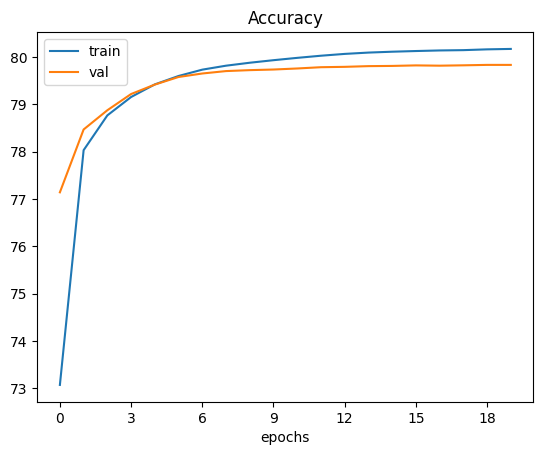

In [53]:
plt.plot(list_train_acc, label="train")
plt.plot(list_val_acc, label="val")
plt.title("Accuracy")
plt.xlabel("epochs")
plt.legend()
plt.xticks(range(0,E,3));

The model performance plateaus at 80% accuracy, it overfits after that.

In [54]:
test_similarity(model, "good", ["movie","actor","story"], ["random","maths","physics"])

{'positive_similarity': tensor([[[[7.4358, 4.2657, 5.6937]]]], device='cuda:0'),
 'negative_similarity': tensor([[[[ 1.1374, -5.7729, -1.3434]]]], device='cuda:0')}

In [56]:
print(test_similarity(
    model, 
    w="actor", 
    Cplus=["bad","good","terrible","handsome","great","absolutely", "actor"], 
    Cminus=["mathematician","robotic","[PAD]","?","Newton","stochastic","reinforcement"]
))

{'positive_similarity': tensor([[[[ 4.0833,  4.2657,  3.1083,  2.4544,  4.4783,  2.3907, 10.0830]]]],
       device='cuda:0'), 'negative_similarity': tensor([[[[-1.3646, -1.5742,  0.0000,  2.7094, -5.9168, -5.9168, -2.2380]]]],
       device='cuda:0')}


a good model should have negative values for words in $C^-$ and positive for $C^+$. Interestingly enough, the token "[PAD]", has a null dot product with every word. This is because we used it as a placeholder.

In [57]:
save_model(model, root="runs/Word2Vec_v1/")

Let's try different things : 
- for tokens at the beginning and end of the reviews, we will add the token itself as their positive context instead of "[PAD]". <br>
  For example the review "I liked this movie" should have (for the word "I" and R=2) $C^+ =$  ["I", "I", "I", "liked", "this"]. <br>
  So that the dot product of a token with itself is high. Using "[PAD]" forces every tokens at the beginning of the reviews, to have a high similarity with "[PAD]", which is not necessarily what we want.
- Reduce the embedding dimension. As we've seen, there is a little bit of overfitting, reducing the size of the embeddings will simplify the model a little bit and reduce overfitting.

In [92]:
gc.collect()

1802

In [127]:
R=4
K=2
B=32
E=20
VOCSIZE=tokenizer.vocab_size
D=100

In [128]:
dataset.shuffle(seed=1)
full_dataset = dataset.select_columns(["review", "sentiment"])
full_dataset = full_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer" : tokenizer}
)
splitted_dataset = full_dataset.train_test_split(0.2)
document_train_set = splitted_dataset["train"]
document_valid_set = splitted_dataset["test"]

In [129]:
def extract_words_contexts(sample, R):
    token_ids = sample["review_ids"]
    n_tokens = len(token_ids)
    positive_context = []
    for i in range(n_tokens):
        # if at the beginning
        if i<R:
            positive_context.append([token_ids[i]]*(R-i) + [token_ids[i+r] for r in range(-i,R+1, 1) if r!=0])
        elif i>=n_tokens-R:
            positive_context.append([token_ids[i+r] for r in range(-R, n_tokens-i, 1) if r!=0] + [token_ids[i]]*(i-n_tokens+R+1))
        else:
            positive_context.append([token_ids[i+r] for r in range(-R, R+1, 1) if r!=0])
    return token_ids, positive_context

In [130]:
def flatten_dataset_to_list(dataset, R):
    '''takes a dataset and returns the token_ids and positive context'''
    token_ids = []
    positive_contexts = []
    for sample in dataset:
        sample_token_ids, positive_context = extract_words_contexts(sample, R)
        token_ids.append(sample_token_ids)
        positive_contexts.append(positive_context)
    return token_ids, positive_contexts

In [131]:
class CustomDataset(Dataset):

    def __init__(self, document_set, R):
        self.document_set = document_set
        token_ids, positive_contexts = flatten_dataset_to_list(document_set, R)
        self.token_ids = torch.tensor(token_ids)
        self.positive_contexts = torch.tensor(positive_contexts)

    def __len__(self):
        return len(self.token_ids)

    def __getitem__(self, idx):
        return {
            "word_id" : self.token_ids[idx], 
            "positive_context_ids" : self.positive_contexts[idx],
        }

In [132]:
# ~ 1 min exec
train_set = CustomDataset(document_train_set, R)
valid_set = CustomDataset(document_valid_set, R)

In [135]:
id = 700
print("First word of the first review :", train_set[id]["word_id"][0])
print("its positive context :", train_set[id]["positive_context_ids"][0])
print("Last word of the first review :", train_set[id]["word_id"][-1])
print("its positive context :", train_set[id]["positive_context_ids"][-1])

First word of the first review : tensor(2757)
its positive context : tensor([2757, 2757, 2757, 2757, 2030, 4142, 1024, 2345])
Last word of the first review : tensor(4523)
its positive context : tensor([ 1011, 13077, 28616,  3270,  4523,  4523,  4523,  4523])


In [138]:
collate_fn_with_params = functools.partial(collate_fn, R=R, K=K, VOCSIZE=VOCSIZE)

train_dataloader = DataLoader(
    train_set, batch_size=B, collate_fn=collate_fn_with_params
)   
valid_dataloader = DataLoader(
    valid_set, batch_size=B, collate_fn=collate_fn_with_params
)
n_valid = len(valid_set)
n_train = len(train_set)

In [139]:
def training(model, E, loss_fn, optimizer, train_dataloader, valid_dataloader, writer):

    # Performance metric tracking
    list_val_acc = []
    list_train_acc = []
    list_train_loss = []
    list_val_loss = []

    for e in range(E):
        # ========== Training ==========
        model.train()
        train_loss = 0.
        acc = 0.
        for batch in tqdm(train_dataloader):
            batch = {k:v.to(DEVICE) for k,v in batch.items()}
            optimizer.zero_grad()
            output = model(batch)
            loss = loss_fn(**output)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().item()
            total_predictions = output["positive_similarity"].shape.numel() + output["negative_similarity"].shape.numel()
            acc += ((torch.sum(output["positive_similarity"]>0)+torch.sum(output["negative_similarity"]<=0))/total_predictions).cpu().item()
        list_train_loss.append(train_loss / len(train_dataloader))
        list_train_acc.append(100 * acc / len(train_dataloader))

        # ========== Validation ==========
        l, a = validation(model, valid_dataloader, loss_fn)
        list_val_loss.append(l)
        list_val_acc.append(a * 100)
        # Tensorboard
        writer.add_scalar("Train loss", list_train_loss[-1], e)
        writer.add_scalar("Val loss", l, e)
        writer.add_scalar("Train acc", list_train_acc[-1], e)
        writer.add_scalar("Val acc", a, e)
        print(
            e,
            "\n\t - Train loss: {:.4f}".format(list_train_loss[-1]),
            "Train acc: {:.4f}".format(list_train_acc[-1]),
            "Val loss: {:.4f}".format(l),
            "Val acc:{:.4f}".format(a * 100),
        )
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [140]:
model = Word2Vec(VOCSIZE, D)
model.to(DEVICE)

Word2Vec(
  (emb): Embedding(30522, 100, padding_idx=0)
)

In [143]:
MyLoss = CustomLoss()

In [118]:
lr=5e-3
Adam = torch.optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter("runs/Word2Vec_v2")

list_train_loss, list_train_acc, list_val_loss, list_val_acc = training(
    model=model,
    E=E,
    loss_fn=MyLoss,
    optimizer=Adam,
    train_dataloader=train_dataloader, 
    valid_dataloader=valid_dataloader,
    writer=writer
)

100%|██████████| 313/313 [00:01<00:00, 268.32it/s]


0 
	 - Train loss: 1.8682 Train acc: 73.3845 Val loss: 1.0477 Val acc:77.7433


100%|██████████| 313/313 [00:01<00:00, 257.53it/s]


1 
	 - Train loss: 0.9473 Train acc: 78.4864 Val loss: 0.8912 Val acc:78.9585


100%|██████████| 313/313 [00:01<00:00, 246.78it/s]


2 
	 - Train loss: 0.8657 Train acc: 79.0669 Val loss: 0.8499 Val acc:79.3005


100%|██████████| 313/313 [00:01<00:00, 210.29it/s]


3 
	 - Train loss: 0.8370 Train acc: 79.4819 Val loss: 0.8305 Val acc:79.6722


100%|██████████| 313/313 [00:01<00:00, 265.35it/s]


4 
	 - Train loss: 0.8221 Train acc: 79.7344 Val loss: 0.8210 Val acc:79.8445


100%|██████████| 313/313 [00:01<00:00, 260.98it/s]


5 
	 - Train loss: 0.8131 Train acc: 79.8943 Val loss: 0.8156 Val acc:79.9603


100%|██████████| 313/313 [00:01<00:00, 236.17it/s]


6 
	 - Train loss: 0.8071 Train acc: 80.0096 Val loss: 0.8125 Val acc:80.0452


100%|██████████| 313/313 [00:01<00:00, 265.03it/s]


7 
	 - Train loss: 0.8028 Train acc: 80.0914 Val loss: 0.8111 Val acc:80.0869


100%|██████████| 313/313 [00:01<00:00, 262.06it/s]


8 
	 - Train loss: 0.7997 Train acc: 80.1422 Val loss: 0.8107 Val acc:80.1128


100%|██████████| 313/313 [00:01<00:00, 237.57it/s]


9 
	 - Train loss: 0.7971 Train acc: 80.1878 Val loss: 0.8105 Val acc:80.1309


100%|██████████| 313/313 [00:01<00:00, 268.29it/s]


10 
	 - Train loss: 0.7952 Train acc: 80.2184 Val loss: 0.8105 Val acc:80.1593


100%|██████████| 313/313 [00:01<00:00, 269.30it/s]


11 
	 - Train loss: 0.7935 Train acc: 80.2497 Val loss: 0.8101 Val acc:80.1846


100%|██████████| 313/313 [00:01<00:00, 274.69it/s]


12 
	 - Train loss: 0.7922 Train acc: 80.2747 Val loss: 0.8104 Val acc:80.1985


100%|██████████| 313/313 [00:01<00:00, 265.91it/s]


13 
	 - Train loss: 0.7909 Train acc: 80.2999 Val loss: 0.8105 Val acc:80.1973


100%|██████████| 313/313 [00:01<00:00, 234.80it/s]


14 
	 - Train loss: 0.7901 Train acc: 80.3132 Val loss: 0.8103 Val acc:80.2170


100%|██████████| 313/313 [00:01<00:00, 267.76it/s]


15 
	 - Train loss: 0.7892 Train acc: 80.3317 Val loss: 0.8106 Val acc:80.2231


100%|██████████| 313/313 [00:01<00:00, 203.74it/s]


16 
	 - Train loss: 0.7887 Train acc: 80.3420 Val loss: 0.8103 Val acc:80.2385


100%|██████████| 313/313 [00:01<00:00, 257.67it/s]


17 
	 - Train loss: 0.7880 Train acc: 80.3533 Val loss: 0.8108 Val acc:80.2409


  3%|▎         | 32/1250 [00:00<00:13, 87.91it/s] 


KeyboardInterrupt: 

Seems slightly better, but not much better either, there is still some overfitting. But we reduced the embedding dimension from 200 to 100 while maintaining the same performance, which is good !

In [125]:
pad_token_id = tokenizer.pad_token_id
print(pad_token_id)
model.emb.weight[pad_token_id]

0


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward0>)

The reason "[PAD]" had a null dot product with every tokens was because it's the null vector.

In [155]:
for i,sample in enumerate(dataset):
    print(len(sample["review"]))
    if i>10:
        break

2500
2537
1117
1537
679
690
857
1571
775
691
860
865


In [143]:
np.clip([len(sample["review"]) for sample in dataset], 0, 256).mean()

255.26204

In [165]:
print(validation(model, valid_dataloader, MyLoss))

100%|██████████| 313/313 [00:01<00:00, 212.34it/s]

(0.8103908273739556, 0.8022715778777394)


What if in the accuracy we slightly modify the definition :
- if the dot product is exactly 0, then the prediction is "positive" (1)
- before, if the dot product was 0, then the prediction would be "negative" (0)

In [170]:
def validation2(model, valid_dataloader, loss_fn):
    model.eval()
    loss_total = 0.
    acc = 0
    with torch.no_grad():
        for batch in tqdm(valid_dataloader):
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            output = model(batch)
            loss = loss_fn(**output)
            loss_total += loss.detach().cpu().item()
            total_predictions = output["positive_similarity"].shape.numel() + output["negative_similarity"].shape.numel()
            acc += ((torch.sum(output["positive_similarity"]>=0)+torch.sum(output["negative_similarity"]<0))/total_predictions).cpu().item()
    return loss_total / len(valid_dataloader), acc / len(valid_dataloader)

In [171]:
print(validation2(model, valid_dataloader, MyLoss))

100%|██████████| 313/313 [00:01<00:00, 210.27it/s]

(0.8112295610836139, 0.7381510730749502)


The loss is roughly the same, but the accuracy metric drops by 6%.

In [172]:
print(test_similarity(
    model, 
    w="actor", 
    Cplus=["bad","good","terrible","handsome","great","absolutely", "actor"], 
    Cminus=["mathematician","robotic","[PAD]","?","Newton","stochastic","reinforcement"]
))

{'positive_similarity': tensor([[[[3.5665, 4.3642, 2.9271, 2.0463, 4.4855, 2.6258, 6.8280]]]],
       device='cuda:0'), 'negative_similarity': tensor([[[[-1.8789, -0.7771,  0.0000,  2.6950, -5.0612, -5.0612, -3.1894]]]],
       device='cuda:0')}


In [173]:
save_model(model, root="runs/Word2Vec_v2/")

Third model : bigger radius

In [144]:
R=8
K=1
B=32
E=20
VOCSIZE=tokenizer.vocab_size
D=100

In [145]:
train_set = CustomDataset(document_train_set, R)
valid_set = CustomDataset(document_valid_set, R)

In [146]:
collate_fn_with_params = functools.partial(collate_fn, R=R, K=K, VOCSIZE=VOCSIZE)

train_dataloader = DataLoader(
    train_set, batch_size=B, collate_fn=collate_fn_with_params
)
valid_dataloader = DataLoader(
    valid_set, batch_size=B, collate_fn=collate_fn_with_params
)
n_valid = len(valid_set)
n_train = len(train_set)

In [147]:
model = Word2Vec(VOCSIZE, D)
model.to(DEVICE)

Word2Vec(
  (emb): Embedding(30522, 100, padding_idx=0)
)

In [148]:
lr=5e-3
Adam = torch.optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter("runs/Word2Vec_v3")

list_train_loss, list_train_acc, list_val_loss, list_val_acc = training(
    model=model,
    E=E,
    loss_fn=MyLoss,
    optimizer=Adam,
    train_dataloader=train_dataloader, 
    valid_dataloader=valid_dataloader,
    writer=writer
)

100%|██████████| 313/313 [00:01<00:00, 218.25it/s]


0 
	 - Train loss: 1.8248 Train acc: 71.9160 Val loss: 1.0217 Val acc:75.8286


100%|██████████| 313/313 [00:01<00:00, 227.97it/s]


1 
	 - Train loss: 0.9359 Train acc: 76.4304 Val loss: 0.8921 Val acc:76.6528


100%|██████████| 313/313 [00:01<00:00, 216.74it/s]


2 
	 - Train loss: 0.8687 Train acc: 76.8612 Val loss: 0.8573 Val acc:76.9228


100%|██████████| 313/313 [00:01<00:00, 226.23it/s]


3 
	 - Train loss: 0.8446 Train acc: 77.1330 Val loss: 0.8417 Val acc:77.1377


100%|██████████| 313/313 [00:01<00:00, 221.88it/s]


4 
	 - Train loss: 0.8327 Train acc: 77.2830 Val loss: 0.8338 Val acc:77.2381


100%|██████████| 313/313 [00:01<00:00, 205.47it/s]


5 
	 - Train loss: 0.8255 Train acc: 77.3814 Val loss: 0.8291 Val acc:77.3232


100%|██████████| 313/313 [00:01<00:00, 234.79it/s]


6 
	 - Train loss: 0.8207 Train acc: 77.4514 Val loss: 0.8268 Val acc:77.3619


100%|██████████| 313/313 [00:01<00:00, 231.19it/s]


7 
	 - Train loss: 0.8174 Train acc: 77.4984 Val loss: 0.8257 Val acc:77.3814


100%|██████████| 313/313 [00:01<00:00, 222.08it/s]


8 
	 - Train loss: 0.8143 Train acc: 77.5470 Val loss: 0.8255 Val acc:77.3883


100%|██████████| 313/313 [00:01<00:00, 220.91it/s]


9 
	 - Train loss: 0.8120 Train acc: 77.5834 Val loss: 0.8259 Val acc:77.3885


100%|██████████| 313/313 [00:01<00:00, 229.14it/s]


10 
	 - Train loss: 0.8099 Train acc: 77.6161 Val loss: 0.8259 Val acc:77.3994


100%|██████████| 313/313 [00:01<00:00, 218.77it/s]


11 
	 - Train loss: 0.8086 Train acc: 77.6376 Val loss: 0.8259 Val acc:77.4115


100%|██████████| 313/313 [00:01<00:00, 227.36it/s]


12 
	 - Train loss: 0.8074 Train acc: 77.6613 Val loss: 0.8259 Val acc:77.4185


100%|██████████| 313/313 [00:01<00:00, 217.10it/s]


13 
	 - Train loss: 0.8066 Train acc: 77.6762 Val loss: 0.8260 Val acc:77.4239


100%|██████████| 313/313 [00:01<00:00, 225.70it/s]


14 
	 - Train loss: 0.8057 Train acc: 77.6908 Val loss: 0.8258 Val acc:77.4308


100%|██████████| 313/313 [00:01<00:00, 218.64it/s]


15 
	 - Train loss: 0.8052 Train acc: 77.6996 Val loss: 0.8260 Val acc:77.4320


100%|██████████| 313/313 [00:01<00:00, 231.10it/s]


16 
	 - Train loss: 0.8045 Train acc: 77.7104 Val loss: 0.8264 Val acc:77.4372


100%|██████████| 313/313 [00:01<00:00, 226.20it/s]


17 
	 - Train loss: 0.8041 Train acc: 77.7225 Val loss: 0.8266 Val acc:77.4405


100%|██████████| 313/313 [00:01<00:00, 222.76it/s]


18 
	 - Train loss: 0.8036 Train acc: 77.7315 Val loss: 0.8263 Val acc:77.4478


100%|██████████| 313/313 [00:01<00:00, 187.29it/s]

19 
	 - Train loss: 0.8032 Train acc: 77.7389 Val loss: 0.8266 Val acc:77.4516


In [151]:
save_model(model, root="runs/Word2Vec_v3/")

Fourth model : same radius, bigger ratio K

In [152]:
R=4
K=4
B=32
E=20
VOCSIZE=tokenizer.vocab_size
D=100

In [153]:
train_set = CustomDataset(document_train_set, R)
valid_set = CustomDataset(document_valid_set, R)

In [154]:
collate_fn_with_params = functools.partial(collate_fn, R=R, K=K, VOCSIZE=VOCSIZE)

train_dataloader = DataLoader(
    train_set, batch_size=B, collate_fn=collate_fn_with_params
)
valid_dataloader = DataLoader(
    valid_set, batch_size=B, collate_fn=collate_fn_with_params
)
n_valid = len(valid_set)
n_train = len(train_set)

In [155]:
model = Word2Vec(VOCSIZE, D)
model.to(DEVICE)

Word2Vec(
  (emb): Embedding(30522, 100, padding_idx=0)
)

In [156]:
lr=5e-3
Adam = torch.optim.Adam(model.parameters(), lr=lr)
writer = SummaryWriter("runs/Word2Vec_v4")

list_train_loss, list_train_acc, list_val_loss, list_val_acc = training(
    model=model,
    E=E,
    loss_fn=MyLoss,
    optimizer=Adam,
    train_dataloader=train_dataloader, 
    valid_dataloader=valid_dataloader,
    writer=writer
)

100%|██████████| 313/313 [00:01<00:00, 174.63it/s]


0 
	 - Train loss: 1.8261 Train acc: 75.0745 Val loss: 1.0261 Val acc:79.2042


100%|██████████| 313/313 [00:01<00:00, 165.12it/s]


1 
	 - Train loss: 0.9286 Train acc: 80.1207 Val loss: 0.8822 Val acc:80.4500


100%|██████████| 313/313 [00:01<00:00, 166.67it/s]


2 
	 - Train loss: 0.8550 Train acc: 80.7487 Val loss: 0.8448 Val acc:80.9695


100%|██████████| 313/313 [00:01<00:00, 174.10it/s]


3 
	 - Train loss: 0.8292 Train acc: 81.2510 Val loss: 0.8283 Val acc:81.3136


100%|██████████| 313/313 [00:01<00:00, 163.79it/s]


4 
	 - Train loss: 0.8162 Train acc: 81.4863 Val loss: 0.8202 Val acc:81.5118


100%|██████████| 313/313 [00:01<00:00, 171.39it/s]


5 
	 - Train loss: 0.8082 Train acc: 81.6494 Val loss: 0.8158 Val acc:81.6465


100%|██████████| 313/313 [00:01<00:00, 175.44it/s]


6 
	 - Train loss: 0.8029 Train acc: 81.7595 Val loss: 0.8135 Val acc:81.7192


100%|██████████| 313/313 [00:01<00:00, 172.48it/s]


7 
	 - Train loss: 0.7992 Train acc: 81.8269 Val loss: 0.8124 Val acc:81.7478


100%|██████████| 313/313 [00:01<00:00, 172.06it/s]


8 
	 - Train loss: 0.7964 Train acc: 81.8704 Val loss: 0.8119 Val acc:81.7774


100%|██████████| 313/313 [00:02<00:00, 141.35it/s]


9 
	 - Train loss: 0.7942 Train acc: 81.8988 Val loss: 0.8118 Val acc:81.7994


100%|██████████| 313/313 [00:02<00:00, 142.98it/s]


10 
	 - Train loss: 0.7923 Train acc: 81.9206 Val loss: 0.8121 Val acc:81.8037


100%|██████████| 313/313 [00:02<00:00, 141.20it/s]


11 
	 - Train loss: 0.7909 Train acc: 81.9416 Val loss: 0.8123 Val acc:81.8285


100%|██████████| 313/313 [00:02<00:00, 149.38it/s]


12 
	 - Train loss: 0.7896 Train acc: 81.9625 Val loss: 0.8129 Val acc:81.8308


100%|██████████| 313/313 [00:02<00:00, 148.29it/s]


13 
	 - Train loss: 0.7886 Train acc: 81.9815 Val loss: 0.8132 Val acc:81.8526


100%|██████████| 313/313 [00:02<00:00, 147.29it/s]


14 
	 - Train loss: 0.7878 Train acc: 81.9976 Val loss: 0.8135 Val acc:81.8673


100%|██████████| 313/313 [00:02<00:00, 149.58it/s]


15 
	 - Train loss: 0.7871 Train acc: 82.0139 Val loss: 0.8134 Val acc:81.8851


100%|██████████| 313/313 [00:02<00:00, 155.61it/s]


16 
	 - Train loss: 0.7866 Train acc: 82.0270 Val loss: 0.8137 Val acc:81.8882


100%|██████████| 313/313 [00:02<00:00, 148.86it/s]


17 
	 - Train loss: 0.7861 Train acc: 82.0410 Val loss: 0.8140 Val acc:81.8961


100%|██████████| 313/313 [00:02<00:00, 145.53it/s]


18 
	 - Train loss: 0.7856 Train acc: 82.0514 Val loss: 0.8139 Val acc:81.9207


100%|██████████| 313/313 [00:01<00:00, 159.16it/s]

19 
	 - Train loss: 0.7851 Train acc: 82.0658 Val loss: 0.8140 Val acc:81.9321


In [157]:
save_model(model, root="runs/Word2Vec_v4/")

We now have 4 models in : 
- runs\Word2Vec_v1\model_dim-200_radius-4_ratio-2-batch-32-epoch-20.ckpt
- runs\Word2Vec_v2\model_dim-100_radius-4_ratio-2-batch-32-epoch-20.ckpt
- runs\Word2Vec_v3\model_dim-100_radius-8_ratio-1-batch-32-epoch-20.ckpt
- runs\Word2Vec_v4\model_dim-100_radius-4_ratio-4-batch-32-epoch-20.ckpt

### 3.3 Classification Task

Reloading everything, so that this part is independent

In [158]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from tabulate import tabulate
from datasets import load_dataset

from tqdm import tqdm
from transformers import BertTokenizer

import functools
from typing import Any
import gc

print("Version de pytorch : ", torch.__version__)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

Version de pytorch :  2.3.0+cu121


device(type='cuda')

In [ ]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

In [160]:
# preprocessing
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)
def preprocessing_fn(x, tokenizer):
    x["review_ids"] = tokenizer(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding='max_length',
        return_attention_mask=False,
    )["input_ids"]
    x["label"] = 0 if x["sentiment"] == "negative" else 1
    return x

dataset.shuffle(seed=1)
full_dataset = dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer" : tokenizer}
)
full_dataset = full_dataset.select_columns(["review_ids", "label"])
splitted_dataset = full_dataset.train_test_split(0.2)
train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]

In [161]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "review_ids" and "label".
        features = [{"input_ids": x["review_ids"]} for x in batch]
        features = self.tokenizer.pad(
            features, padding="max_length", max_length=256, return_tensors="pt"
        )
        label = torch.tensor([x["label"] for x in batch])[:, None]
        return {"review_ids": features["input_ids"], "label": label}

data_collator = DataCollator(tokenizer)

B = 32

train_dataloader = DataLoader(
    train_set, batch_size=B, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=B, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

In [170]:
B = 32 # batch size
D = 100 # embedding dim
VOCSIZE = tokenizer.vocab_size
epochs = 5

1. Write a function load_model that takes a path to a saved Word2Vec
embeddings (with the previous formatting) and loads the checkpoint the
embeddings directly to the ConvolutionModel (you can use either the
state-of-the art model or the first small model).

In [163]:
class ConvolutionModel(nn.Module):

    def __init__(self, emb_weights, channels, kernel_size, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.vocsize, self.emb_dim = emb_weights.shape
        self.emb = nn.Embedding(self.vocsize, self.emb_dim, padding_idx=0)
        self.emb.weight = emb_weights
        
        self.conv = nn.Conv1d(self.emb_dim, channels, kernel_size)
        self.activ = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(output_size=1)
        self.dropout = nn.Dropout(p=0.5)
        self.hidden_layers = nn.Sequential(
            self.conv, self.activ, self.pool, self.dropout
        )
        self.lin = nn.Linear(channels, 1)

    def __call__(self, input_ids):
        '''input_ids (B, L) 
        where B is batch_size, L is max_length, D is emb_dim, C is channels'''
        emb = self.emb(input_ids).mT # (B,L) -> emb -> (B,L,D) -> .mT -> (B,D,L)
        return self.lin(self.hidden_layers(emb).squeeze()) # (B,D,L) -> hidden_layers -> (B,C,1) -> squeeze -> (B,C) ->  (B,1)

In [164]:
def load_model(model_filepath, *args, **kwargs):
    embeddings_weights = torch.load(model_filepath)
    model = ConvolutionModel(embeddings_weights, *args, **kwargs)
    return model

In [94]:
cls_model = load_model(
    model_filepath=r"runs\Word2Vec_v2\model_dim-100_radius-4_ratio-2-batch-32-epoch-20.ckpt",
    channels=8,
    kernel_size=3,
)

In [95]:
cls_model.to(DEVICE)

ConvolutionModel(
  (emb): Embedding(30522, 100, padding_idx=0)
  (conv): Conv1d(100, 8, kernel_size=(3,), stride=(1,))
  (activ): ReLU()
  (pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (hidden_layers): Sequential(
    (0): Conv1d(100, 8, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): AdaptiveAvgPool1d(output_size=1)
    (3): Dropout(p=0.5, inplace=False)
  )
  (lin): Linear(in_features=8, out_features=1, bias=True)
)

In [96]:
test_input = torch.randint(0, VOCSIZE, size=(32,256)).to(DEVICE)
cls_model(test_input).shape

torch.Size([32, 1])

In [97]:
next(iter(train_dataloader))["label"].shape

torch.Size([32, 1])

2. Train the model, initialized with these embeddings

In [165]:
def validation(model, valid_dataloader, loss_fn):
    model.eval()
    with torch.no_grad():
        total_loss = 0.
        correct = 0
        for batch in tqdm(valid_dataloader):
            input_ids, target = batch["review_ids"].to(DEVICE), batch["label"].float().to(DEVICE)
            output = model(input_ids)
            loss = loss_fn(output, target)
            total_loss += loss.detach().cpu().item()
            correct += ((output>=0) == target).float().sum().cpu().item()
    return total_loss / len(valid_dataloader), 100*correct / (len(valid_dataloader)*valid_dataloader.batch_size)

In [166]:
def training(model, E, loss_fn, optimizer, train_dataloader, valid_dataloader, writer):

    # Performance metric tracking
    list_val_acc = []
    list_train_acc = []
    list_train_loss = []
    list_val_loss = []

    for e in range(E):
        # ========== Training ==========
        model.train()
        train_loss = 0.
        correct = 0
        for batch in tqdm(train_dataloader):
            input_ids, target = batch["review_ids"].to(DEVICE), batch["label"].float().to(DEVICE)
            optimizer.zero_grad()
            output = model(input_ids)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().cpu().item()
            correct += ((output>=0) == target).float().sum().cpu().item()
        list_train_loss.append(train_loss / len(train_dataloader))
        list_train_acc.append(100 * correct / (len(train_dataloader) * train_dataloader.batch_size))

        # ========== Validation ==========
        l, a = validation(model, valid_dataloader, loss_fn)
        list_val_loss.append(l)
        list_val_acc.append(a)
        # Tensorboard
        writer.add_scalar("Train loss", list_train_loss[-1], e)
        writer.add_scalar("Val loss", list_val_loss[-1], e)
        writer.add_scalar("Train acc", list_train_acc[-1], e)
        writer.add_scalar("Val acc", list_val_acc[-1], e)
        print(
            e,
            "\n\t - Train loss: {:.4f}".format(list_train_loss[-1]),
            "Train acc: {:.4f}".format(list_train_acc[-1]),
            "Val loss: {:.4f}".format(l),
            "Val acc:{:.4f}".format(a),
        )
    return list_train_loss, list_train_acc, list_val_loss, list_val_acc

In [100]:
BCE = nn.BCEWithLogitsLoss()
lr = 5e-3
Adam = torch.optim.Adam(cls_model.parameters(), lr)
writer = SummaryWriter("runs/Classification_pretrained_v2")

list_train_loss, list_train_acc, list_val_loss, list_val_acc = training(
    cls_model,
    epochs,
    BCE,
    Adam,
    train_dataloader,
    valid_dataloader,
    writer,
)

100%|██████████| 313/313 [00:02<00:00, 137.71it/s]


0 
	 - Train loss: 0.4623 Train acc: 77.4725 Val loss: 0.3322 Val acc:87.3103


100%|██████████| 313/313 [00:02<00:00, 134.55it/s]


1 
	 - Train loss: 0.3734 Train acc: 82.8700 Val loss: 0.3148 Val acc:86.8411


100%|██████████| 313/313 [00:02<00:00, 141.45it/s]


2 
	 - Train loss: 0.3365 Train acc: 84.9050 Val loss: 0.3107 Val acc:87.1006


100%|██████████| 313/313 [00:02<00:00, 135.24it/s]


3 
	 - Train loss: 0.3028 Train acc: 86.7575 Val loss: 0.3219 Val acc:86.4617


100%|██████████| 313/313 [00:02<00:00, 142.86it/s]

4 
	 - Train loss: 0.2800 Train acc: 87.7100 Val loss: 0.3457 Val acc:85.5831


3. Compare the results with the model without this initialization.

In [113]:
cls_model2 = ConvolutionModel(
    emb_weights=torch.nn.parameter.Parameter(torch.randn(VOCSIZE, D)),
    channels=8,
    kernel_size=3
)
cls_model2.to(DEVICE)

ConvolutionModel(
  (emb): Embedding(30522, 100, padding_idx=0)
  (conv): Conv1d(100, 8, kernel_size=(3,), stride=(1,))
  (activ): ReLU()
  (pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (hidden_layers): Sequential(
    (0): Conv1d(100, 8, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): AdaptiveAvgPool1d(output_size=1)
    (3): Dropout(p=0.5, inplace=False)
  )
  (lin): Linear(in_features=8, out_features=1, bias=True)
)

In [114]:
BCE = nn.BCEWithLogitsLoss()
lr = 5e-3
Adam = torch.optim.Adam(cls_model2.parameters(), lr)
writer = SummaryWriter("runs/Classification_scratch")

list_train_loss, list_train_acc, list_val_loss, list_val_acc = training(
    cls_model2,
    epochs,
    BCE,
    Adam,
    train_dataloader,
    valid_dataloader,
    writer,
)

100%|██████████| 313/313 [00:02<00:00, 146.61it/s]


0 
	 - Train loss: 0.4944 Train acc: 75.0150 Val loss: 0.3348 Val acc:86.5615


100%|██████████| 313/313 [00:02<00:00, 148.09it/s]


1 
	 - Train loss: 0.3860 Train acc: 82.8100 Val loss: 0.3159 Val acc:86.8910


100%|██████████| 313/313 [00:02<00:00, 149.70it/s]


2 
	 - Train loss: 0.3433 Train acc: 85.1850 Val loss: 0.3146 Val acc:86.6114


100%|██████████| 313/313 [00:02<00:00, 143.52it/s]


3 
	 - Train loss: 0.3187 Train acc: 86.3675 Val loss: 0.3198 Val acc:86.3618


100%|██████████| 313/313 [00:02<00:00, 139.95it/s]

4 
	 - Train loss: 0.2960 Train acc: 87.8225 Val loss: 0.3319 Val acc:86.0823


**4. Make a small ablation study on the influence of some parameters of the
Word2Vec model on the classification task. Analyze the results.**

Word2Vec_v3 : D=100, R=8, K=1, B=32, E=20

In [168]:
cls_model3 = load_model(model_filepath=r"runs\Word2Vec_v3\model_dim-100_radius-8_ratio-1-batch-32-epoch-20.ckpt", channels=8, kernel_size=3)
cls_model3.to(DEVICE)

ConvolutionModel(
  (emb): Embedding(30522, 100, padding_idx=0)
  (conv): Conv1d(100, 8, kernel_size=(3,), stride=(1,))
  (activ): ReLU()
  (pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (hidden_layers): Sequential(
    (0): Conv1d(100, 8, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): AdaptiveAvgPool1d(output_size=1)
    (3): Dropout(p=0.5, inplace=False)
  )
  (lin): Linear(in_features=8, out_features=1, bias=True)
)

In [171]:
BCE = nn.BCEWithLogitsLoss()
lr = 5e-3
Adam = torch.optim.Adam(cls_model3.parameters(), lr)
writer = SummaryWriter("runs/Classification_pretrained_v3")

list_train_loss, list_train_acc, list_val_loss, list_val_acc = training(
    cls_model3,
    epochs,
    BCE,
    Adam,
    train_dataloader,
    valid_dataloader,
    writer,
)

100%|██████████| 313/313 [00:02<00:00, 147.90it/s]


0 
	 - Train loss: 0.4836 Train acc: 75.5775 Val loss: 0.3438 Val acc:85.8027


100%|██████████| 313/313 [00:02<00:00, 144.32it/s]


1 
	 - Train loss: 0.3963 Train acc: 81.7150 Val loss: 0.3287 Val acc:85.7728


100%|██████████| 313/313 [00:02<00:00, 147.61it/s]


2 
	 - Train loss: 0.3518 Train acc: 84.2900 Val loss: 0.3360 Val acc:84.9740


100%|██████████| 313/313 [00:02<00:00, 133.36it/s]


3 
	 - Train loss: 0.3208 Train acc: 86.1300 Val loss: 0.3463 Val acc:84.8642


100%|██████████| 313/313 [00:02<00:00, 146.17it/s]

4 
	 - Train loss: 0.2948 Train acc: 87.3275 Val loss: 0.3707 Val acc:83.6761


Word2Vec_v4 : D=100, R=4, K=4, B=32, E=20

In [174]:
cls_model4 = load_model(model_filepath=r"runs\Word2Vec_v4\model_dim-100_radius-4_ratio-4-batch-32-epoch-20.ckpt", channels=8, kernel_size=3)
cls_model4.to(DEVICE)

ConvolutionModel(
  (emb): Embedding(30522, 100, padding_idx=0)
  (conv): Conv1d(100, 8, kernel_size=(3,), stride=(1,))
  (activ): ReLU()
  (pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (hidden_layers): Sequential(
    (0): Conv1d(100, 8, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): AdaptiveAvgPool1d(output_size=1)
    (3): Dropout(p=0.5, inplace=False)
  )
  (lin): Linear(in_features=8, out_features=1, bias=True)
)

In [175]:
BCE = nn.BCEWithLogitsLoss()
lr = 5e-3
Adam = torch.optim.Adam(cls_model4.parameters(), lr)
writer = SummaryWriter("runs/Classification_pretrained_v4")

list_train_loss, list_train_acc, list_val_loss, list_val_acc = training(
    cls_model4,
    epochs,
    BCE,
    Adam,
    train_dataloader,
    valid_dataloader,
    writer,
)

100%|██████████| 313/313 [00:02<00:00, 138.97it/s]


0 
	 - Train loss: 0.4714 Train acc: 76.6275 Val loss: 0.3256 Val acc:86.9010


100%|██████████| 313/313 [00:02<00:00, 143.26it/s]


1 
	 - Train loss: 0.3820 Train acc: 82.6150 Val loss: 0.3132 Val acc:86.9708


100%|██████████| 313/313 [00:02<00:00, 145.64it/s]


2 
	 - Train loss: 0.3407 Train acc: 85.1500 Val loss: 0.3247 Val acc:86.1322


100%|██████████| 313/313 [00:02<00:00, 146.41it/s]


3 
	 - Train loss: 0.3096 Train acc: 86.8975 Val loss: 0.3324 Val acc:86.1222


100%|██████████| 313/313 [00:02<00:00, 139.19it/s]

4 
	 - Train loss: 0.2877 Train acc: 87.7125 Val loss: 0.3527 Val acc:85.1038


Word2Vec_v1 : D=200, R=4, K=2, B=32, E=20

In [177]:
cls_model1 = load_model(model_filepath=r"runs\Word2Vec_v1\model_dim-200_radius-4_ratio-2-batch-32-epoch-20.ckpt", channels=8, kernel_size=3)
cls_model1.to(DEVICE)

ConvolutionModel(
  (emb): Embedding(30522, 200, padding_idx=0)
  (conv): Conv1d(200, 8, kernel_size=(3,), stride=(1,))
  (activ): ReLU()
  (pool): AdaptiveAvgPool1d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (hidden_layers): Sequential(
    (0): Conv1d(200, 8, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): AdaptiveAvgPool1d(output_size=1)
    (3): Dropout(p=0.5, inplace=False)
  )
  (lin): Linear(in_features=8, out_features=1, bias=True)
)

In [178]:
BCE = nn.BCEWithLogitsLoss()
lr = 5e-3
Adam = torch.optim.Adam(cls_model1.parameters(), lr)
writer = SummaryWriter("runs/Classification_pretrained_v1")

list_train_loss, list_train_acc, list_val_loss, list_val_acc = training(
    cls_model1,
    epochs,
    BCE,
    Adam,
    train_dataloader,
    valid_dataloader,
    writer,
)

100%|██████████| 313/313 [00:02<00:00, 145.51it/s]


0 
	 - Train loss: 0.4645 Train acc: 76.8925 Val loss: 0.3338 Val acc:86.7312


100%|██████████| 313/313 [00:02<00:00, 152.68it/s]


1 
	 - Train loss: 0.3787 Train acc: 82.8900 Val loss: 0.3167 Val acc:86.6314


100%|██████████| 313/313 [00:02<00:00, 156.31it/s]


2 
	 - Train loss: 0.3387 Train acc: 85.3125 Val loss: 0.3175 Val acc:86.7612


100%|██████████| 313/313 [00:02<00:00, 152.83it/s]


3 
	 - Train loss: 0.3107 Train acc: 86.6875 Val loss: 0.3309 Val acc:86.1122


100%|██████████| 313/313 [00:02<00:00, 151.40it/s]

4 
	 - Train loss: 0.2834 Train acc: 88.1950 Val loss: 0.3513 Val acc:85.6230


Analysis :
R=8, K=1 is worse than (R=4,K=2). The best we've had is (R=4,K=4). <br>
So too big radius is not good, it may yield consider tokens that have nothing in common to have close embeddings. <br>
D=100 is better than D=200 (embedding dimension) <br>
Because for our small classification problem it overfits, 100 is enough. <br>

Having pretrained embeddings is better for the classfication, though the difference between a pretrained and a one randomly initialized one doesn't seem that big. We only observe a difference before epoch 1, after that it catches up quickly, at leatst for our classification problem.